In [8]:
from gworacle import query, mass, snr
from astropy.utils.data import download_file
import json, numpy
from pycbc import init_logging
import json
from pycbc.cosmology import redshift
from pycbc.conversions import mchirp_from_mass1_mass2

sigma_scale = 1.65 # Use ~90% interval

events = json.load(open('./class_massest.json', 'r'))
events2 = json.load(open('./massest.json', 'r'))

mchirp_sky = {}
mchirp_sky_val = {}
mchirp_sky_sus = {}
mchirp_sky_sus2 = {}

for event in events2:
    e = events2[event]

    #if e['far'] > 2 / (86400 * 365.25):
    #    continue
    
    z = redshift(e['dist'])

    if e['dist'] - e['distsigma'] * sigma_scale < 0:
        zm = 0
    else:
        zm = redshift(e['dist'] - e['distsigma'] * sigma_scale)

    zp = redshift(e['dist'] + e['distsigma'] * sigma_scale)


    mcd = mchirp_from_mass1_mass2(e['mest'][0], e['mest'][0]) 
    mc = mcd / (1 + z)
    mcl = mc - mcd / (1 + zp)
    mcu = mcd / (1 + zm) - mc
    
    mcd2 = mchirp_from_mass1_mass2(e['mest2'][0], e['mest2'][0]) 
    mc2 = mcd2 / (1 + z)
    mcl2 = mc2 - mcd2 / (1 + zp)
    mcu2 = mcd2 / (1 + zm) - mc2

    if event not in events or events[event]['mest'] is None:
        if e['mlimit'] < e['mest'][0]:
            mchirp_sky_sus[event] = (mc, mcl, mcu, e['snr']['snr'], e['snr']['snr_err'], e['time'])
            mchirp_sky_sus2[event] = (mc2, mcl2, mcu2, e['snr']['snr'], e['snr']['snr_err'], e['time'])
        else:
            mchirp_sky_val[event] = (mc, mcl, mcu, e['snr']['snr'], e['snr']['snr_err'], e['time'])
        
    mchirp_sky[event] = (mc, mcl, mcu, e['snr']['snr'], e['snr']['snr_err'], e['time'])

print(len(mchirp_sky.keys()), len(mchirp_sky_val.keys()), len(mchirp_sky_sus.keys()))


259 219 12


In [58]:
from matplotlib import pyplot as plt
from pycbc.conversions import mchirp_from_mass1_mass2
from astropy.utils.data import download_file
import numpy

sigma_scale = 1.65 # Use ~90% interval
syst = 0.2

# Read through 4-ogc text file
names = "event 	 srcmass1 	 srcmass1_plus 	 srcmass1_minus 	 srcmass2 	 srcmass2_plus 	 srcmass2_minus 	 srcmchirp 	 srcmchirp_plus 	 srcmchirp_minus 	 q 	 q_plus 	 q_minus 	 chi_eff 	 chi_eff_plus 	 chi_eff_minus 	 distance 	 distance_plus 	 distance_minus 	 redshift 	 redshift_plus 	 redshift_minus 	 remnantmass 	 remnantmass_plus 	 remnantmass_minus 	 remnantspin 	 remnantspin_plus 	 remnantspin_minus 	 snr 	 detmass1 	 detmass1_plus 	 detmass1_minus 	 detmass2 	 detmass2_plus 	 detmass2_minus 	 detmchirp 	 detmchirp_plus 	 detmchirp_minus 	 detremnantmass 	 detremnantmass_plus 	 detremnantmass_minus".split(' ')
names = [name for name in names if name != '\t']
c = download_file("https://raw.githubusercontent.com/gwastro/4-ogc/refs/heads/master/posterior/PEtable.txt", cache=True)
cat = numpy.genfromtxt(c, dtype=str, delimiter=',')
cat2 = {}
cat2 = {name: numpy.array(cat[:,i+1], dtype=float) for i, name in enumerate(names[1:])}
cat2['event'] = cat[:,0]

snr = cat2['snr']
k = snr > 0
mcc =cat2["srcmchirp"][k]
mcl = cat2["srcmchirp_plus"][k] # These are alaredy 90% intervals from 4-ogc by default
mcu = cat2["srcmchirp_minus"][k]
mcce = (mcu + mcl) / 2

# Estimates for low mass events
mc1 = numpy.array([events[k]['mest'] for k in events])
snr1 = numpy.array([events[k]['snr']['snr'] for k in events])

distsig = numpy.array([events[k]['distsigma'] for k in events])
dist = numpy.array([events[k]['dist'] for k in events])

zl = redshift(dist - distsig * sigma_scale)
zu = redshift(dist + distsig * sigma_scale)
z = redshift(dist)

mcr = mc1 * (1 + z)
mcu1 = mcr / (1 + zl) - mc1
mcl1 = mc1 - mcr / (1 + zu)
mce1 = (mcu1 + mcl1) / 2.0 / sigma_scale 

mc3 = numpy.array([mchirp_sky_val[e][0] for e in mchirp_sky_val if mchirp_sky_val[e][5] > 1308835218])
mcl3 = numpy.array([mchirp_sky_val[e][1] for e in mchirp_sky_val if mchirp_sky_val[e][5] > 1308835218])
mcu3 = numpy.array([mchirp_sky_val[e][2] for e in mchirp_sky_val if mchirp_sky_val[e][5] > 1308835218])
snr3 = numpy.array([mchirp_sky_val[e][3] for e in mchirp_sky_val if mchirp_sky_val[e][5] > 1308835218])
mce3 = (mcu3 + mcl3) / 2.0 / sigma_scale + syst / sigma_scale * mc3

mc2 = numpy.array([mchirp_sky_sus[e][0] for e in mchirp_sky_sus if mchirp_sky_sus[e][5] > 1308835218]) 
mcl2 = numpy.array([mchirp_sky_sus[e][1] for e in mchirp_sky_sus if mchirp_sky_sus[e][5] > 1308835218])
mcu2 = numpy.array([mchirp_sky_sus[e][2] for e in mchirp_sky_sus if mchirp_sky_sus[e][5] > 1308835218])
snr2 = numpy.array([mchirp_sky_sus[e][3] for e in mchirp_sky_sus if mchirp_sky_sus[e][5] > 1308835218])
mce2 = (mcu2 + mcl2) / 2.0 / sigma_scale + syst / sigma_scale * mc2

mc4 = numpy.array([mchirp_sky_sus2[e][0] for e in mchirp_sky_sus2 if mchirp_sky_sus2[e][5] > 1308835218])
mcl4 = numpy.array([mchirp_sky_sus2[e][1] for e in mchirp_sky_sus2 if mchirp_sky_sus2[e][5] > 1308835218])
mcu4 = numpy.array([mchirp_sky_sus2[e][2] for e in mchirp_sky_sus2 if mchirp_sky_sus2[e][5] > 1308835218])
snr4 = numpy.array([mchirp_sky_sus2[e][3] for e in mchirp_sky_sus if mchirp_sky_sus[e][5] > 1308835218])
mce4 = (mcu4 + mcl4) / 2.0 / sigma_scale + syst / sigma_scale * mc4

In [88]:
import h5py
from pycbc.conversions import mchirp_from_mass1_mass2
import math
from numpy.random import normal
from scipy.special import logsumexp

sthresh = 10
mc_tot = numpy.concatenate([mcc[snr>sthresh], mc1[snr1>sthresh], mc4[snr4>sthresh],  mc3[snr3>sthresh]])
mc_err = numpy.concatenate([mcce[snr>sthresh], mce1[snr1>sthresh], mce4[snr4>sthresh],  mce3[snr3>sthresh]])

f = h5py.File('./vt_chirp_10.hdf', 'r')
f2 = h5py.File('./vt_chirp_10_O13.hdf', 'r')

srcm = f['srcmasses'][:]
srcvt = f['vt_src'][:] + f2['vt_src'][:] 

bins = [[1, 1.5], [1.5, 3.5], [3.5, 100], [3.5, 10], [10, 100], [10, 17], [17, 50], [50, 100]]

#bins = [[17, 50]]

def post(rate, k):
    prior =  1 / rate ** 0.5 # Jeffrey's prior on the individual (?
    #post = prior * rate ** k * numpy.exp(-rate) #/ math.factorial(k)

    logpost = numpy.log(prior) + numpy.log(rate) * k - rate
    return logpost

for b in bins:
    dt = 0
    rate = numpy.arange(.001, 1000, .001)
    rrate = numpy.arange(.001, 1000, .001)
    
    for j in range(400):
        mcval = mc_tot + normal(size=len(mc_tot)) * mc_err# Normal distribution approximation here
        vtmc = numpy.interp(mcval, mchirp_from_mass1_mass2(srcm, srcm), srcvt)
        
        k = (mc_tot > b[0]) & (mc_tot < b[1])
        r = (1 / vtmc[k]).sum()

        v = post(rate, k.sum())
        v = numpy.exp(v - logsumexp(v))

        dtp = numpy.interp(rrate, rate * r / k.sum(), v)
        dt += dtp / dtp.sum()
        idx2 = numpy.searchsorted(dt.cumsum() / dt.sum(), [0.05, 0.5, .95])

        idx = numpy.searchsorted(v.cumsum() / v.sum(), [0.05, 0.5, 0.95])
        cint = rate[idx] / k.sum()
        
    
    #print(b, k.sum(), r, r * cint, rrate[idx2])
    print(b, k.sum(), r, rrate[idx2])

[1, 1.5] 2 55.99039340803073 [ 16.035  60.917 155.003]
[1.5, 3.5] 5 35.517262526089894 [15.653 35.403 67.421]
[3.5, 100] 206 19.27482673549372 [17.162 19.7   23.088]
[3.5, 10] 47 15.276466180127125 [12.425 16.155 20.912]
[10, 100] 159 3.838618018473163 [2.979 3.544 4.35 ]
[10, 17] 20 1.7716786518545158 [1.086 1.667 2.488]
[17, 50] 132 1.8259444188645564 [1.517 1.843 2.359]
[50, 100] 7 0.014806686254735447 [0.006 0.013 0.029]


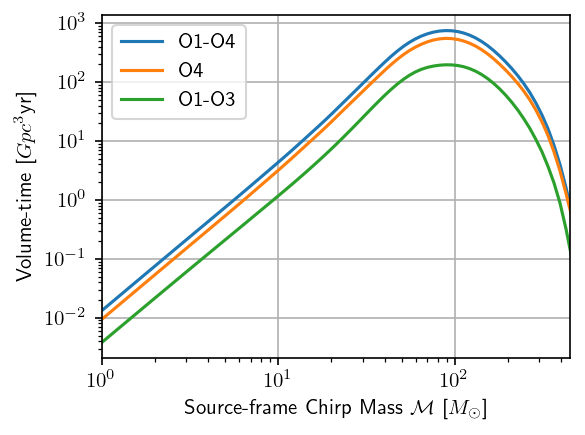

In [51]:
srcm = f['srcmasses'][:]
srcvt = f['vt_src'][:] + f2['vt_src'][:]

from matplotlib import pyplot as plt

plt.rc('text', usetex=True)
plt.figure(figsize=[4,3], dpi=150)
plt.plot(srcm, srcvt, label='O1-O4')

plt.plot(srcm, f['vt_src'][:], label='O4')
plt.plot(srcm, f2['vt_src'][:], label='O1-O3')

plt.xscale('log')
plt.yscale('log')
plt.xlim(1, 450)
plt.xlabel('Source-frame Chirp Mass $\mathcal{M}$ [$M_\odot$]')
plt.legend()
plt.grid()
plt.ylabel('Volume-time [$Gpc^3 $yr]')
plt.tight_layout()
plt.savefig('selection.pdf')